# Principled Bayesian hierarchical drift-diffusion modelling: A practical primer


## Outline
### 1. Preparation
#### 1.1 How to install HDDM container (on different platforms)
#### 1.2 How to use the container, e.g., Open Jupyter Notebook or other IDE.

### 2. A pipeline of principled Bayesian hierarchical DDM
#### 2.1 Brief description of DDM and DDM parameters
#### 2.2 Priors selection and prior predictive check
#### 2.3 Model estimation
#### 2.4 Convergence check
#### 2.5 Parameter recovery
#### 2.6 Model comparison (e.g., information criteria)
#### 2.7 Posterior predictive check

### 3. Interpreting and reporting of statistical results
#### 3.1 Intepreting parameters and inference 
#### 3.2 Tyipcal pitfalls in parameter interpretations


## Useful functions for beginners

Plot an illustration of DDM with [seaborn](https://seaborn.pydata.org/)

Plot the priors used in HDDM and how to change prior

Plot MCMC trace using seaborn.

Prior predictive check

Plot individual PPC results using [seaborn](https://seaborn.pydata.org/) or [arviz](https://arviz-devs.github.io/arviz/examples/index.html)

Plot group-level posterior with pair plot with seaborn

1. Overview of the sequantial sampling models and toolbox (maybe we can create a table based on [Ratcliff et al. 2016](https://www.cell.com/trends/cognitive-sciences/fulltext/S1364-6613(16)00025-5)). briefly. a table.

2. motivation: (1) implicit knowledge; (2)
2. Guide for selecting models (?)
3. Tutorial on how to use HDDM, following the ten simple rules.

## Introduction
#### Brief description of DDM and DDM parameters

From (Matzke and Wagenmakes, 2009)
* Drift rate $v$ represents the mean rate of information accumulation and is determined by the quality of information that is extracted from the stimulus. Drift rate can be influenced either by individual differences in the quality of information processing or by stimulus characteristics that reflect task difficulty. 
* Boundary separation $a$ quantifies the distance between the two response boundaries and represents response caution. Large values of $a$ indicate that more information must be accumulated before a decision can be made. Boundary separation is usually manipulated via speed–accuracy instructions. 
* Starting point $z$ represents participants’ a priori bias for one of the two response alternatives. Starting point is usually manipulated either by varying the proportions of stimuli associated with the upper and lower response boundaries or by payoff manipulations. Both a and $z$ are assumed to be under the subjective control of participants. 
* Nondecision time $Ter$ quantifies the duration of processes that are unrelated to the decision process, including stimulus encoding and response execution.

## 1 Preparation
#### 1.1 How to install

#### 1.2 How to use container

### Full diffusion model (HDDM)

Wiecki et al. (2013):

$$ x_{i,j}  \sim F(a_{i}, z_{i}, v_{i}, t_{i}, sv, st, sz)$$, 
where $x_{i,j}$ represents the observed data consisting of response time and choice of subject $i$ on trial $j$ and $F$ represents the DDM likelihood function as formulated by Navarro and Fuss (2009).


Navarro and Fuss (2009): Wiener first passage time (WFPT) distribution. 

relative starting point: $ w = z/a $. The probability density function for the WFPT distribution, which describes the chance that the diffusion process is absorbed at time $t$ at the **lower boundary** will be denoted by $f(t|v, a, w)$:

$$f(t|v, a, w) = \frac{\pi}{a^2}exp \left(-vaw - \frac{v^2 t}{2}\right) \sum_{k=1}^{\infty} k exp \left(-\frac{k^2 \pi^2 t}{2 a^2} \right) sin(k \pi w).$$


#### Prior selection and prior check

Steps for prior check

Current prior in HDDM, weakly informative prior, was based on Matzke & Wagenmakes (2009, Appendix A, and supplementary). Note, Matzke and Wagenmakes (2009) summaried 23 papers (?# of experiments, participants?) and provided the frequencies of **9** parameters, but Wiekie et al (2013) defined **12** parameters.

$a_{j} \sim \mathcal{G}(\mu_{a}, \sigma_{a}^2)$, $ \mu_{a} \sim \mathcal{G}(1.50, 0.75)$, $\sigma_{a} \sim \mathcal{HN}(0.1)$; 

$v_{j} \sim \mathcal{N}(\mu_{v}, \sigma_{v}^2)$, $ \mu_{v} \sim \mathcal{N}(2.00, 3.00)$, $\sigma_{v} \sim \mathcal{HN}(2.0)$; 

$z_{j} \sim invlogit(\mathcal{N}(\mu_{z}, \sigma_{z}^2))$, $ \mu_{z} \sim \mathcal{N}(0.50, 0.50)$; $\sigma_{z} \sim \mathcal{HN}(0.05)$; 

$t_{j} \sim \mathcal{N}(\mu_{t}, \sigma_{t}^2)$, $ \mu_{t} \sim \mathcal{G}(0.40, 0.20)$, $\sigma_{t} \sim \mathcal{HN}(1)$; 

$ \mathcal{sv} \sim \mathcal{HN}(2)$; $ \mathcal{st} \sim \mathcal{HN}(0.3)$; $\mathcal{sz} \sim \mathcal{B}(1, 3)$  

The above prior were specified at `hddm/models/hddm_info.py`, line 115 - 160
critical func is `_create_stochastic_knodes(self, include)`, this defines the free parameter based on the input.  `_create_stochastic_knodes(self, include)` will define the distribution of each parameter using functions in `hddm/models/base.py`, such as `_create_family_gamma_gamma_hnormal`, these function further depends on `pymc/distribution.py`, in which the class name were re-capitalized ('half_normal' -> 'HalfNormal').

One question left: parameter `value` in these functions. It might be the "Starting value"


Possible new priors: Tran, N.-H., Maanen, L. van, Heathcote, A., & Matzke, D. (2020). Systematic Quantitative Parameter Reviews in Cognitive Modeling: Towards Robust and Cumulative Models of Psychological Processes. https://doi.org/10.31234/osf.io/6jyf3


def _create_stochastic_knodes_info(self, include):
        knodes = OrderedDict()
        if 'a' in include:
            knodes.update(self._create_family_gamma_gamma_hnormal('a', g_mean=1.5, g_std=0.75, std_std=2, std_value=0.1, value=1))
        if 'v' in include:
            knodes.update(self._create_family_normal_normal_hnormal('v', value=2, g_mu=2, g_tau=3**-2, std_std=2))
        if 't' in include:
            knodes.update(self._create_family_gamma_gamma_hnormal('t', g_mean=.4, g_std=0.2, value=0.001, std_std=1, std_value=0.2))
        if 'sv' in include:
            knodes['sv_bottom'] = Knode(pm.HalfNormal, 'sv', tau=2**-2, value=1, depends=self.depends['sv'])
        if 'sz' in include:
            knodes['sz_bottom'] = Knode(pm.Beta, 'sz', alpha=1, beta=3, value=0.01, depends=self.depends['sz'])
        if 'st' in include:
            knodes['st_bottom'] = Knode(pm.HalfNormal, 'st', tau=0.3**-2, value=0.001, depends=self.depends['st'])
        if 'z' in include:
            knodes.update(self._create_family_invlogit('z', value=.5, g_tau=0.5**-2, std_std=0.05))
        if 'p_outlier' in include:
            knodes['p_outlier_bottom'] = Knode(pm.Beta, 'p_outlier', alpha=1, beta=15, value=0.01, depends=self.depends['p_outlier'])
            
def _create_family_gamma_gamma_hnormal(self, name, value=1, g_mean=1, g_std=1, std_std=2, std_value=.1):

        knodes = OrderedDict()
        g_shape = (g_mean**2) / (g_std**2)
        g_rate = g_mean / (g_std**2)
        if self.is_group_model and name not in self.group_only_nodes:
            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate,
                            value=g_mean, depends=self.depends[name])
            depends_std = self.depends[name] if self.std_depends else ()
            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
                        value=std_value, depends=depends_std)

            shape = Knode(pm.Deterministic, '%s_shape' % name, eval=lambda x,y: (x**2)/(y**2),
                        x=g, y=std, plot=False, trace=False, hidden=True)

            rate = Knode(pm.Deterministic, '%s_rate' % name, eval=lambda x,y: x/(y**2),
                        x=g, y=std, plot=False, trace=False, hidden=True)


            subj = Knode(pm.Gamma, '%s_subj'%name, alpha=shape, beta=rate,
                         value=value, depends=('subj_idx',),
                         subj=True, plot=False)

            knodes['%s'%name]            = g
            knodes['%s_std'%name]        = std
            knodes['%s_rate'%name]       = rate
            knodes['%s_shape'%name]      = shape
            knodes['%s_bottom'%name]     = subj

        else:
            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate, value=value,
                            depends=self.depends[name])

            knodes['%s_bottom'%name] = g

        return knodes
        
 def _create_family_normal_normal_hnormal(self, name, value=0, g_mu=None,
                             g_tau=15**-2, std_std=2,
                             std_value=.1):
        """Create a family of knodes. A family is a group of knodes
        that belong together.
        For example, a family could consist of the following distributions:
        * group mean g_mean (Normal(g_mu, g_tau))
        * group standard deviation g_std (Uniform(std_lower, std_upper))
        * transform node g_std_trans for g_std (x -> x**-2)
        * subject (Normal(g_mean, g_std_trans))
        In fact, if is_group_model is True and the name does not appear in
        group_only nodes, this is the family that will be created.
        Otherwise, only a Normal knode will be returned.
        :Arguments:
            name : str
                Name of the family. Each family member will have this name prefixed.
        :Optional:
            value : float
                Starting value.
            g_mu, g_tau, std_lower, std_upper, std_value : float
                The hyper parameters for the different family members (see above).
        :Returns:
            OrderedDict: member name -> member Knode
        """
        if g_mu is None:
            g_mu = value

        knodes = OrderedDict()

        if self.is_group_model and name not in self.group_only_nodes:
            g = Knode(pm.Normal, '%s' % name, mu=g_mu, tau=g_tau,
                      value=value, depends=self.depends[name])
            depends_std = self.depends[name] if self.std_depends else ()
            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
                        value=std_value, depends=depends_std)
            tau = Knode(pm.Deterministic, '%s_tau' % name,
                        doc='%s_tau' % name, eval=lambda x: x**-2, x=std,
                        plot=False, trace=False, hidden=True)
            subj = Knode(pm.Normal, '%s_subj' % name, mu=g, tau=tau,
                         value=value, depends=('subj_idx',),
                         subj=True, plot=self.plot_subjs)
            knodes['%s'%name] = g
            knodes['%s_std'%name] = std
            knodes['%s_tau'%name] = tau
            knodes['%s_bottom'%name] = subj

        else:
            subj = Knode(pm.Normal, name, mu=g_mu, tau=g_tau,
                         value=value, depends=self.depends[name])

            knodes['%s_bottom'%name] = subj

        return knodes

Steps for prior check

Step 1: random sample 4 parameter from the prior;

Step 2: generate data using these 4 parameters

Step 3: calculate the mean of RT from the generated data

Step 4: using some cutoff for the RTs

Step 5: reverse back to the priors that generated data with the cutoff.

In [1]:
import hddm
import pymc as pm

import numpy as np
import statistics
from scipy.stats import halfnorm

import matplotlib.pyplot as plt
import seaborn as sns


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


##### Draw a random value from prior distribution of $a$

$$ a_{j} \sim \mathcal{G}(\mu_{a}, \sigma_{a}^2) $$, $$ \mu_{a} \sim \mathcal{G}(1.50, 0.75)$$, $$\sigma_{a} \sim \mathcal{HN}(0.1)$$ 

mean of mu_a:  1.506718297028982
std of mu_a:  0.748654892408492
std of std_a:  (4.5362164603362845e-05, 0.09538224856727992)


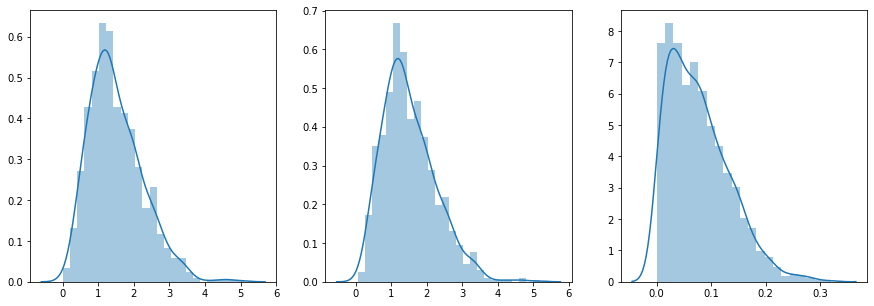

In [2]:
# draw a random a from the prior

# in hddm_info.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_gamma_gamma_hnormal('a', g_mean=1.5, g_std=0.75, 
#                                                            std_std=2, std_value=0.1, value=1))

# def _create_family_gamma_gamma_hnormal(self, name, value=1, g_mean=1, g_std=1, std_std=2, std_value=.1):
#        knodes = OrderedDict()
#        g_shape = (g_mean**2) / (g_std**2)
#        g_rate = g_mean / (g_std**2)
#        if self.is_group_model and name not in self.group_only_nodes:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate,
#                            value=g_mean, depends=self.depends[name])
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)#
#
#            shape = Knode(pm.Deterministic, '%s_shape' % name, eval=lambda x,y: (x**2)/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#            rate = Knode(pm.Deterministic, '%s_rate' % name, eval=lambda x,y: x/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#            subj = Knode(pm.Gamma, '%s_subj'%name, alpha=shape, beta=rate,
#                         value=value, depends=('subj_idx',),
#                         subj=True, plot=False)
#
#            knodes['%s'%name]            = g
#            knodes['%s_std'%name]        = std
#            knodes['%s_rate'%name]       = rate
#            knodes['%s_shape'%name]      = shape
#            knodes['%s_bottom'%name]     = subj
#
#        else:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate, value=value,
#                            depends=self.depends[name])
#
#            knodes['%s_bottom'%name] = g
#
#        return knodes

# in `pymc/distribution.py`
# the gamma distribution
# def rgamma(alpha, beta, size=None):
#     """
#     Random gamma variates.
#     """
#
#     return np.random.gamma(shape=alpha, scale=1. / beta, size=size)

# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """
#
#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

def draw_a_prior(g_mean=1.5, g_std=0.75, std_std=2, std_value=0.1, size = 1):
    g_shape = (g_mean**2) / (g_std**2)
    g_rate = g_mean / (g_std**2)
    g_beta=g_rate
    
    g = np.random.gamma(shape=g_shape, scale = 1./ g_beta, size = size)
    
    # tau=std_std**-2 # why using std_std instead of std_value?
    tau=std_value**-2 # using std_value?
    std = abs(np.random.normal(0, np.sqrt(1 / tau), size=size))
    
    shape = (g**2)/(std**2)
    
    rate = g/(std**2)
    
    beta = rate
    
    subj_a = np.random.gamma(shape=shape, scale = 1./ beta, size=size)
    
    return subj_a, g, std

subj_a, g, std = draw_a_prior(size = 1000)
# print(subj_a)

print('mean of mu_a: ', statistics.mean(g))
print('std of mu_a: ', statistics.stdev(g))
print('std of std_a: ', halfnorm.fit(std))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_a, ax = axes[0])
sns.distplot(g, ax = axes[1])
sns.distplot(std, ax = axes[2])

##### Draw a value from prior of $t$. 

In Wiecki et al (2013), the prior of $t$ was written as below:

$$t_{j} \sim \mathcal{N}(\mu_{t}, \sigma_{t}^2)$$ $$ \mu_{t} \sim \mathcal{G}(0.40, 0.20)$$ $$\sigma_{t} \sim \mathcal{HN}(1)$$

However, in the `hddm/models/hddm_info.py#L128`, the code defins the prior distribution was `knodes.update(self._create_family_gamma_gamma_hnormal('t', g_mean=.4, g_std=0.2, value=0.001, std_std=1, std_value=0.2))`, which is the same as `a`. Even though it was different from but it's reasonable because `t` should not be negative.

So, the actual prior used was:

$$t_{j} \sim \mathcal{G}(\mu_{t}, \sigma_{t}^2)$$ $$ \mu_{t} \sim \mathcal{G}(0.40, 0.20)$$ $$\sigma_{t} \sim \mathcal{HN}(1)$$

mean of mu_t:  0.40328639523461457
std of mu_t:  0.20469592896362285
std of std_t:  (0.004131269691754279, 0.9815528012317718)


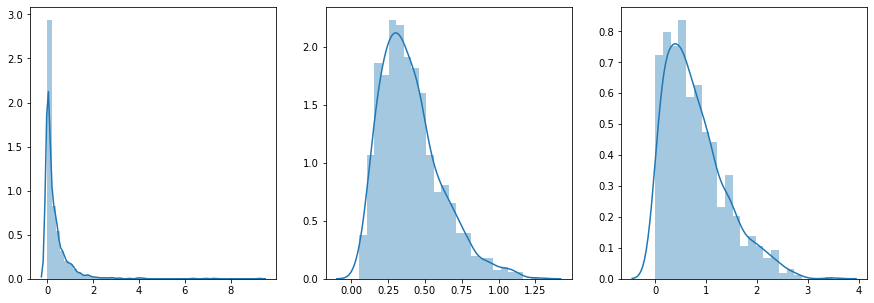

In [3]:
# draw a random t from the prior

# in hddminfo.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_gamma_gamma_hnormal('t', g_mean=.4, g_std=0.2, value=0.001, std_std=1, std_value=0.2))
#
# in hddm/models/base.py
# def _create_family_gamma_gamma_hnormal(self, name, value=1, g_mean=1, g_std=1, std_std=2, std_value=.1):
#
#        knodes = OrderedDict()
#        g_shape = (g_mean**2) / (g_std**2)
#        g_rate = g_mean / (g_std**2)
#        if self.is_group_model and name not in self.group_only_nodes:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate,
#                            value=g_mean, depends=self.depends[name])
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)#
#
#            shape = Knode(pm.Deterministic, '%s_shape' % name, eval=lambda x,y: (x**2)/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#            rate = Knode(pm.Deterministic, '%s_rate' % name, eval=lambda x,y: x/(y**2),
#                        x=g, y=std, plot=False, trace=False, hidden=True)
#
#
#            subj = Knode(pm.Gamma, '%s_subj'%name, alpha=shape, beta=rate,
#                         value=value, depends=('subj_idx',),
#                         subj=True, plot=False)
#
#            knodes['%s'%name]            = g
#            knodes['%s_std'%name]        = std
#            knodes['%s_rate'%name]       = rate
#            knodes['%s_shape'%name]      = shape
#            knodes['%s_bottom'%name]     = subj
#
#        else:
#            g = Knode(pm.Gamma, name, alpha=g_shape, beta=g_rate, value=value,
#                            depends=self.depends[name])
#
#            knodes['%s_bottom'%name] = g
#
#        return knodes

# in `pymc/distribution.py`
# the gamma distribution
# def rgamma(alpha, beta, size=None):
#     """
#     Random gamma variates.
#     """
#
#     return np.random.gamma(shape=alpha, scale=1. / beta, size=size)


# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """
#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

# in `pymc/distribution.py`
# def rnormal(mu, tau, size=None):
#     """
#     Random normal variates.
#     """
#     return np.random.normal(mu, 1. / np.sqrt(tau), size)

def draw_t_prior(g_mean=.4, g_std=0.2, value=0.001, std_std=1, std_value=0.2, size=1):
    g_shape = (g_mean**2) / (g_std**2)
    g_rate = g_mean / (g_std**2)
    g_beta=g_rate
    
    g = np.random.gamma(shape=g_shape, scale = 1./ g_beta, size = size)
    
    tau_g =std_std**-2 # why using std_std instead of std_value?
    std = abs(np.random.normal(0, np.sqrt(1 / tau_g), size=size))
    
    #tau = std ** -2
    shape = (g**2)/(std**2)
    
    rate = g/(std**2)
    
    beta = rate
    
    #subj_t = np.random.normal(g, 1. / np.sqrt(tau), size)
    subj_t = np.random.gamma(shape=shape, scale = 1./ beta, size=size)
    
    return subj_t, g, std

subj_t, g, std = draw_t_prior(size = 1000)
# list = [subj_t, g, std]
# param_t = pd.DataFrame(data = list, columns= ["subj_t", "g", "std"])

#print(subj_t)

print('mean of mu_t: ', statistics.mean(g))
print('std of mu_t: ', statistics.stdev(g))
print('std of std_t: ', halfnorm.fit(std))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_t, ax = axes[0])
sns.distplot(g, ax = axes[1])
sns.distplot(std, ax = axes[2])

##### Draw a random value from prior distribution of $v$

$v_{j} \sim \mathcal{N}(\mu_{v}, \sigma_{v}^2)$, $ \mu_{v} \sim \mathcal{N}(2.00, 3.00)$, $\sigma_{v} \sim \mathcal{HN}(2.0)$; 

mean of mu_v:  2.0774670619452733
std of mu_v:  3.082236070694619
std of std_v:  (0.005172369193637463, 2.0336621528425027)


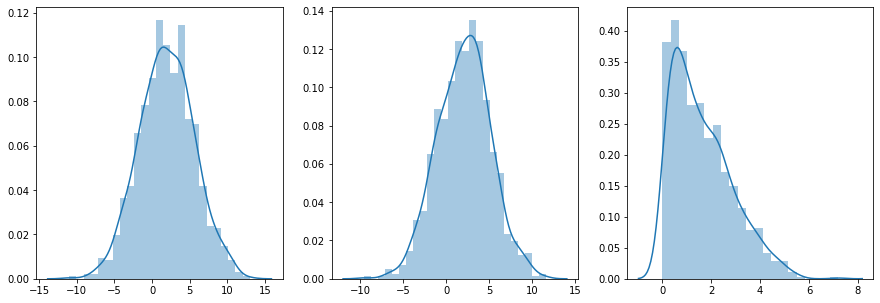

In [4]:
# draw a random a from the prior

# in hddminfo.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_normal_normal_hnormal('v', value=2, g_mu=2, g_tau=3**-2, std_std=2))

# in hddm/models/base.py
# def _create_family_normal_normal_hnormal(self, name, value=0, g_mu=None,
#                              g_tau=15**-2, std_std=2,
#                              std_value=.1):
#         """Create a family of knodes. A family is a group of knodes
#         that belong together.
#         For example, a family could consist of the following distributions:
#         * group mean g_mean (Normal(g_mu, g_tau))
#         * group standard deviation g_std (Uniform(std_lower, std_upper))
#         * transform node g_std_trans for g_std (x -> x**-2)
#         * subject (Normal(g_mean, g_std_trans))
#         In fact, if is_group_model is True and the name does not appear in
#         group_only nodes, this is the family that will be created.
#         Otherwise, only a Normal knode will be returned.
#         :Arguments:
#             name : str
#                 Name of the family. Each family member will have this name prefixed.
#         :Optional:
#             value : float
#                 Starting value.
#             g_mu, g_tau, std_lower, std_upper, std_value : float
#                 The hyper parameters for the different family members (see above).
#         :Returns:
#             OrderedDict: member name -> member Knode
#         """
#         if g_mu is None:
#             g_mu = value
# 
#         knodes = OrderedDict()
#
#        if self.is_group_model and name not in self.group_only_nodes:
#            g = Knode(pm.Normal, '%s' % name, mu=g_mu, tau=g_tau,
#                      value=value, depends=self.depends[name])
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)
#            tau = Knode(pm.Deterministic, '%s_tau' % name,
#                        doc='%s_tau' % name, eval=lambda x: x**-2, x=std,
#                        plot=False, trace=False, hidden=True)
#            subj = Knode(pm.Normal, '%s_subj' % name, mu=g, tau=tau,
#                         value=value, depends=('subj_idx',),
#                         subj=True, plot=self.plot_subjs)
#            knodes['%s'%name] = g
#            knodes['%s_std'%name] = std
#            knodes['%s_tau'%name] = tau
#            knodes['%s_bottom'%name] = subj

#        else:
#            subj = Knode(pm.Normal, name, mu=g_mu, tau=g_tau,
#                         value=value, depends=self.depends[name])

#            knodes['%s_bottom'%name] = subj
#
#        return knodes


# in `pymc/distribution.py`

# in `pymc/distribution.py`
# def rnormal(mu, tau, size=None):
#     """
#     Random normal variates.
#     """
#     return np.random.normal(mu, 1. / np.sqrt(tau), size)

# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """

#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

def draw_v_prior(value=2, g_mu=2,g_tau=3**-2, std_std=2, size=1):
    if g_mu is None:
        g_mu = value
    
    g = np.random.normal(g_mu, 1. / np.sqrt(g_tau), size=size)
    tau_g=std_std**-2
    
    std_g = abs(np.random.normal(0, 1./ np.sqrt(tau_g), size=size)) # half-normal distribution
    
    tau = std_std ** -2
    #print('tau', tau)
    subj_v = np.random.normal(g, 1./ np.sqrt(tau), size=size)
    
    return subj_v, g, std_g
    
subj_v, g, std_g = draw_v_prior(size=1000)
#print(subj_v)

print('mean of mu_v: ', statistics.mean(g))
print('std of mu_v: ', statistics.stdev(g))
print('std of std_v: ', halfnorm.fit(std_g))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_v, ax = axes[0])
sns.distplot(g, ax = axes[1])
sns.distplot(std_g, ax = axes[2])

##### Draw a value of $z$ from its' prior:

$z_{j} \sim invlogit(\mathcal{N}(\mu_{z}, \sigma_{z}^2))$, $ \mu_{z} \sim \mathcal{N}(0.50, 0.50)$; $\sigma_{z} \sim \mathcal{HN}(0.05)$; 

mean of mu_z:  0.46103791166277414
std of mu_z:  0.5123751783743091
std of std_z:  (4.2038857434280606e-05, 0.04914529836691748)


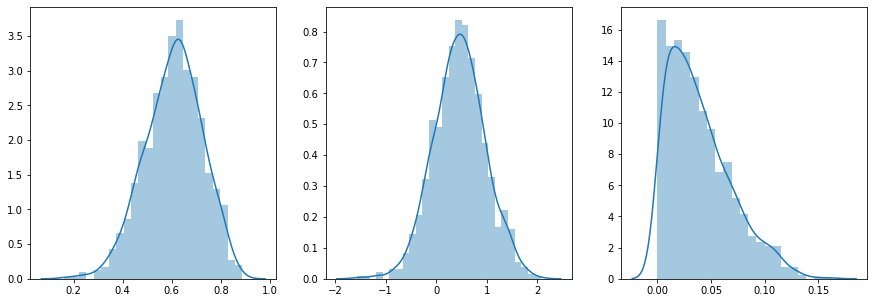

In [6]:
# draw a random z from the prior

# in hddminfo.py `_create_stochastic_knodes_info`
# knodes.update(self._create_family_invlogit('z', value=.5, g_tau=0.5**-2, std_std=0.05))

# def _create_family_invlogit(self, name, value, g_mu=None, g_tau=15**-2,
#                               std_std=0.2, std_value=.1):
#        """Similar to _create_family_normal_normal_hnormal() but adds a invlogit
#        transform knode to the subject and group mean nodes. This is useful
#        when the parameter space is restricted from [0, 1].
#        See _create_family_normal_normal_hnormal() help for more information.
#        """
#
#        if g_mu is None:
#            g_mu = value
#
#        # logit transform values
#        value_trans = np.log(value) - np.log(1-value) 
#        g_mu_trans = np.log(g_mu) - np.log(1-g_mu) # when g_mu = value = 0.5, g_mu_trans = 0
#
#        knodes = OrderedDict()
#
#        if self.is_group_model and name not in self.group_only_nodes:
#            g_trans = Knode(pm.Normal,
#                            '%s_trans'%name,
#                            mu=g_mu_trans,
#                            tau=g_tau,
#                            value=value_trans,
#                            depends=self.depends[name],
#                            plot=False,
#                            hidden=True)
#
#            g = Knode(pm.InvLogit, name, ltheta=g_trans, plot=True, trace=True)
#
#            depends_std = self.depends[name] if self.std_depends else ()
#            std = Knode(pm.HalfNormal, '%s_std' % name, tau=std_std**-2,
#                        value=std_value, depends=depends_std)
#
#            tau = Knode(pm.Deterministic, '%s_tau'%name, doc='%s_tau'
#                        % name, eval=lambda x: x**-2, x=std,
#                        plot=False, trace=False, hidden=True)
#
#            subj_trans = Knode(pm.Normal, '%s_subj_trans'%name,
#                               mu=g_trans, tau=tau, value=value_trans,
#                               depends=('subj_idx',), subj=True,
#                               plot=False, hidden=True)
#
#            subj = Knode(pm.InvLogit, '%s_subj'%name,
#                         ltheta=subj_trans, depends=('subj_idx',),
#                         plot=self.plot_subjs, trace=True, subj=True)
#
#            knodes['%s_trans'%name]      = g_trans
#            knodes['%s'%name]            = g
#            knodes['%s_std'%name]        = std
#            knodes['%s_tau'%name]        = tau
#
#            knodes['%s_subj_trans'%name] = subj_trans
#            knodes['%s_bottom'%name]     = subj
#
#        else:
#            g_trans = Knode(pm.Normal, '%s_trans'%name, mu=g_mu_trans,
#                            tau=g_tau, value=value_trans,
#                            depends=self.depends[name], plot=False, hidden=True)
#
#            g = Knode(pm.InvLogit, '%s'%name, ltheta=g_trans, plot=True,
#                      trace=True )
#
#            knodes['%s_trans'%name] = g_trans
#            knodes['%s_bottom'%name] = g
#
#        return knodes

# in `pymc/distribution.py`
# def rnormal(mu, tau, size=None):
#     """
#     Random normal variates.
#     """
#     return np.random.normal(mu, 1. / np.sqrt(tau), size)

# InvLogit in `pymc/CommonDeterministics.py` <-- invlogit in `pymc/utils.py#L84` <-- `flib.f` (Fortran)
# invlogit in utils.py#L84
# def invlogit(ltheta):
#     return flib.invlogit(ravel(ltheta)).reshape(shape(ltheta))
# numpy.ravel = reshape(-1, order=order), return a contiguous flattened array.

# replace with invlogit in pymc3?
# `pymc3/math.py#L193`
# def invlogit(x, eps=sys.float_info.epsilon):
#     """The inverse of the logit function, 1 / (1 + exp(-x))."""
#    return (1.0 - 2.0 * eps) / (1.0 + tt.exp(-x)) + eps

# can replace `tt` with `np`? yes, almost the same.

# the half_normal ditribution
# def rhalf_normal(tau, size=None):
#     """
#     Random half-normal variates.
#     """

#     return abs(np.random.normal(0, np.sqrt(1 / tau), size))

import sys
def invlogit(ltheta, eps=sys.float_info.epsilon):
    """The inverse of the logit function, 1 / (1 + exp(-x))."""
    ltheta = np.array(ltheta, dtype=np.float128)
    return (1.0 - 2.0 * eps) / (1.0 + np.exp(-ltheta)) + eps

def draw_z_prior(value=.5, g_mu = None, g_tau=0.5**-2, std_std=0.05, size=1):
    
    if g_mu is None:
        g_mu = value
    g_mu_trans = g_mu
    
    # g_mu_trans = np.log(g_mu) - np.log(1-g_mu) #### this deviate from prior!!
    g_trans = np.random.normal(g_mu_trans, 1. / np.sqrt(g_tau), size)
    #print('g_trans is: ', g_trans)
    g = invlogit(ltheta=g_trans)
    
    #print('g is: ', g)
    
    g_tau = std_std**-2
    #print('g_tau is: ', g_tau)
    
    g_std = abs(np.random.normal(0, np.sqrt(1. / g_tau), size=size)) # half normal
    #print('g_std is: ', g_std)
    
    tau = g_std ** -2
    subj_trans = np.random.normal(g_trans, np.sqrt(1./tau), size=size)
    #print('subj_trans is: ', subj_trans)
    #print('tau is: ', tau)
#
    subj_z = invlogit(ltheta=subj_trans)
    
    return subj_z, g_trans, g_std
 
subj_z, g_trans, g_std = draw_z_prior(size=1000)
#z_std = abs(np.random.normal(0, 0.05. ** -2, size = size)) # half normal
#z_mu = np.random.normal(0.5, 0.5 ** -2, size = size)

#v = np.random.normal(v_mu, v_std**-2)
#print(subj_z)


print('mean of mu_z: ', statistics.mean(g_trans))
print('std of mu_z: ', statistics.stdev(g_trans))
print('std of std_z: ', halfnorm.fit(g_std))

f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(subj_z, ax = axes[0])
sns.distplot(g_trans, ax = axes[1])
sns.distplot(g_std, ax = axes[2])

In [29]:
tmp1 = hddm.generate.gen_rand_params()
tmp1
# type(tmp1)

{'sv': 0,
 'sz': 0,
 'st': 0,
 'z': 0.5,
 'v': -0.4211249060415714,
 't': 0.46198859805598536,
 'a': 1.027035964260195}

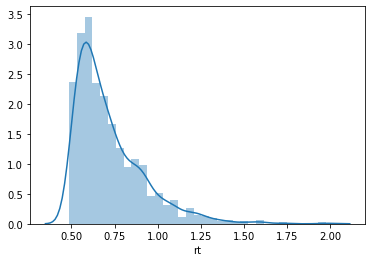

In [46]:
# tmp = hddm.generate.gen_rand_data({'z':tmp1['z'], 't':tmp1['t'], 'v':tmp1['v'], 'a':tmp1['a'],}, size=1000, subjs=1)

tmp = hddm.generate.gen_rand_data(tmp1, size=1000, subjs=1)

tmp[0].rt

import seaborn as sns
sns.distplot(tmp[0].rt)


In [33]:
# draw a random from all 7 parameters as the prior has specified
import numpy as np

std_a = None
while std_a == None:
    tmp = np.random.normal(loc=0.0, scale=0.1, size=1)
    if tmp > 0:
        std_a = tmp

# note that in Wieckie 2013, Gamma distribution was define by mean and rate
# which is not directly corresponding to the numpy's gamma (shape or α, scale or β)
# rate is an inverse scale parameter β =1/θ, which means θ=1/β
# mean parameter μ = kθ = α/β, which mean α = β * μ

mu_a = np.random.gamma(shape = (1.5**2)/(0.75**2), scale= 1.5 / (0.75**2), size=1)

# mu = mu_a, sigma = sigma_a --> alpha (shape) = beta * mu = (1/sigma) * mu = mu_a * (1/sigma_a); beta = 1/sigma_a
a_1 =  np.random.gamma(shape = (mu_a**2) /(std_a**2), scale=mu_a/(std_a**2), size=1)

print(mu_a, std_a ** 2, a_1)

[7.6067483] [0.00509494] [16969830.83466574]


In [31]:
1/(sigma_a ** 2)

array([30.92149286])